In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

import warnings
warnings.filterwarnings(action='ignore')

import rdkit
import rdkit.Chem
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, MACCSkeys
from rdkit.Chem.SaltRemover import SaltRemover

import pandas as pd
import numpy as np
import math
from typing import List
from scipy import interp
import pickle
import time   #Transfer learning 
import sys
import argparse
import logging
import json
from tqdm import tnrange, tqdm_notebook

import keras
from keras import backend as K
from keras import layers
from keras.models import Sequential, Model
from keras.utils import get_file, get_source_inputs
from keras_applications.imagenet_utils import _obtain_input_shape, preprocess_input as _preprocess
from keras_efficientnets.config import BlockArgs, get_default_block_list
from keras_efficientnets.custom_objects import EfficientNetConvInitializer
from keras_efficientnets.custom_objects import EfficientNetDenseInitializer
from keras_efficientnets.custom_objects import Swish, DropConnect
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.activations import elu, sigmoid
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, MaxPooling2D, Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

import matplotlib.patches as patches
import matplotlib.pylab as plt
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import average_precision_score, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import matthews_corrcoef, roc_curve, auc, cohen_kappa_score

from imblearn.metrics import sensitivity_specificity_support, 
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

%matplotlib inline
print("RDKit: %s"%rdkit.__version__)
print("Keras: %s"%keras.__version__)

RDKit: 2020.03.3


In [2]:
remover = SaltRemover()
def remove_nonbonded(smiles):
    a=[]
    smiles_split = smiles.split(".")
    for i in range(0,len(smiles_split)):
        a.append(len(smiles_split[i]))
    return smiles_split[a.index(max(a))]

In [3]:

def smiles_to_finger_MACCS(smiles):
    mol_1 = Chem.MolFromSmiles(smiles)
    mol_1.MACCS = MACCSkeys.GenMACCSKeys(mol_1).ToBitString()
    prac = np.array(list(mol_1.MACCS))
    return prac


In [4]:
def smiles_to_finger(smiles,radian=2,nBits=1024):
    
    mol_1 = Chem.MolFromSmiles(smiles)
    mol_1.ecfp4 = AllChem.GetMorganFingerprintAsBitVect(mol_1,radian,nBits)
    prac = np.array(list(mol_1.ecfp4.ToBitString()))
    return prac


In [5]:
def gmean_score(y_true,y_pred):
    tn,fp,fn,tp = confusion_matrix(y_true,y_pred).ravel()
    return ((tp/(tp+fn))*(tn/(tn+fp)))**(1/2)

# Train Set Import

In [6]:
data = pd.read_csv('Data/BBB_1114.csv',header=0)
gene= pd.read_csv('Data/rm_tani_maccs_gene_BBB_0325.csv',header=0)

In [7]:
gene=pd.concat([gene.iloc[:,0],pd.DataFrame(np.repeat(0,len(gene)))],axis=1)
gene.columns=['SMILES','n_np']

In [8]:
c= []
d= []
for i in range(0,len(gene)):
    try:
        c.append(Chem.MolToSmiles(Chem.MolFromSmiles(gene['SMILES'][i]))) 
       # a.append(Chem.MolToSmiles(Chem.MolFromSmiles(data['SMILES'][i])))
    except:
        d.append(i)
        pass

In [9]:
gene3 = gene.drop(gene.index[d])
gene3 =gene3.reset_index()

# Chemcepterize_mol

In [10]:
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    #print(dims)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    #print(coords)
    vect = np.zeros((dims,dims,4)) ## vacuum,  shape(image_width, image_height,4 channels)
    #Bonds first layer, encoded the bondorder
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number :2nd layer
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges :3rd layer
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization : 4th layer
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect

In [11]:
def vectorize(mol,embed=20):
    return chemcepterize_mol(mol,embed=embed)

In [12]:
e= []
f=[]
for i in range(0,len(gene3)):
    try:
        e.append(vectorize(Chem.MolFromSmiles(gene['SMILES'][i]),embed=21))
       # a.append(Chem.MolToSmiles(Chem.MolFromSmiles(data['SMILES'][i])))
    except:
        f.append(i)
        pass

In [14]:
gene4 = gene3.drop(gene3.index[f])
gene4 =gene4.reset_index()

In [15]:
gene3=gene4.copy()

In [17]:
gene3.n_np.value_counts()

0    910
Name: n_np, dtype: int64

# Inception arichtecture


In [20]:
def round_filters(filters, width_coefficient, depth_divisor, min_depth):
    """Round number of filters based on depth multiplier."""
    multiplier = float(width_coefficient)
    divisor = int(depth_divisor)
    min_depth = min_depth

    if not multiplier:
        return filters

    filters *= multiplier
    min_depth = min_depth or divisor
    new_filters = max(min_depth, int(filters + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_filters < 0.9 * filters:
        new_filters += divisor

    return int(new_filters)

In [21]:
def round_repeats(repeats, depth_coefficient):
    """Round number of filters based on depth multiplier."""
    multiplier = depth_coefficient

    if not multiplier:
        return repeats

    return int(math.ceil(multiplier * repeats))

In [22]:
def SEBlock(input_filters, se_ratio, expand_ratio, data_format=None):
    if data_format is None:
        data_format = K.image_data_format()

    num_reduced_filters = max(
        1, int(input_filters * se_ratio))
    filters = input_filters * expand_ratio

    if data_format == 'channels_first':
        channel_axis = 1
        spatial_dims = [2, 3]
    else:
        channel_axis = -1
        spatial_dims = [1, 2]

    def block(inputs):
        x = inputs
        x = layers.Lambda(lambda a: K.mean(a, axis=spatial_dims, keepdims=True))(x)
        x = layers.Conv2D(
            num_reduced_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=EfficientNetConvInitializer(),
            padding='same',
            use_bias=True)(x)
        x = Swish()(x)
        # Excite
        x = layers.Conv2D(
            filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=EfficientNetConvInitializer(),
            padding='same',
            use_bias=True)(x)
        x = layers.Activation('sigmoid')(x)
        out = layers.Multiply()([x, inputs])
        return out

    return block

In [23]:
def MBConvBlock(input_filters, output_filters,
                kernel_size, strides,
                expand_ratio, se_ratio,
                id_skip, drop_connect_rate,
                batch_norm_momentum=0.99,
                batch_norm_epsilon=1e-3,
                data_format=None):

    if data_format is None:
        data_format = K.image_data_format()

    if data_format == 'channels_first':
        channel_axis = 1
        spatial_dims = [2, 3]
    else:
        channel_axis = -1
        spatial_dims = [1, 2]

    has_se = (se_ratio is not None) and (se_ratio > 0) and (se_ratio <= 1)
    filters = input_filters * expand_ratio

    def block(inputs):

        if expand_ratio != 1:
            x = layers.Conv2D(
                filters,
                kernel_size=[1, 1],
                strides=[1, 1],
                kernel_initializer=EfficientNetConvInitializer(),
                padding='same',
                use_bias=False)(inputs)
            x = layers.BatchNormalization(
                axis=channel_axis,
                momentum=batch_norm_momentum,
                epsilon=batch_norm_epsilon)(x)
            x = Swish()(x)
        else:
            x = inputs

        x = layers.DepthwiseConv2D(
            [kernel_size, kernel_size],
            strides=strides,
            depthwise_initializer=EfficientNetConvInitializer(),
            padding='same',
            use_bias=False)(x)
        x = layers.BatchNormalization(
            axis=channel_axis,
            momentum=batch_norm_momentum,
            epsilon=batch_norm_epsilon)(x)
        x = Swish()(x)

        if has_se:
            x = SEBlock(input_filters, se_ratio, expand_ratio,
                        data_format)(x)

        # output phase

        x = layers.Conv2D(
            output_filters,
            kernel_size=[1, 1],
            strides=[1, 1],
            kernel_initializer=EfficientNetConvInitializer(),
            padding='same',
            use_bias=False)(x)
        x = layers.BatchNormalization(
            axis=channel_axis,
            momentum=batch_norm_momentum,
            epsilon=batch_norm_epsilon)(x)

        if id_skip:
            if all(s == 1 for s in strides) and (
                    input_filters == output_filters):

                # only apply drop_connect if skip presents.
                if drop_connect_rate:
                    x = DropConnect(drop_connect_rate)(x)

                x = layers.Add()([x, inputs])

        return x

    return block


In [24]:
def EfficientNet(input_shape,
                 block_args_list: List[BlockArgs],
                 width_coefficient: float,
                 depth_coefficient: float,
                 dropout_rate=0.2,
                 batch_norm_momentum=0.99,
                 batch_norm_epsilon=1e-3,
                 depth_divisor=8,
                 min_depth=None,
                 data_format=None,
                drop_connect_rate=0.,
                 pooling='max'):
  




    if data_format is None:
        data_format = K.image_data_format()

    if data_format == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    if block_args_list is None:
        block_args_list = get_default_block_list()

    # count number of strides to compute min size
    stride_count = 1
    for block_args in block_args_list:
        if block_args.strides is not None and block_args.strides[0] > 1:
            stride_count += 1

    min_size = int(2 ** stride_count)

    # Determine proper input shape and default size.

    input_img =  layers.Input(shape=input_shape.shape.as_list()[1:])
  
    x = input_img
    x = layers.Conv2D(
        filters=round_filters(32, width_coefficient,
                              depth_divisor, min_depth),
        kernel_size=[3, 3],
        strides=[2, 2],
        kernel_initializer=EfficientNetConvInitializer(),
        padding='same',
        use_bias=False)(x)
    x = layers.BatchNormalization(
        axis=channel_axis,
        momentum=batch_norm_momentum,
        epsilon=batch_norm_epsilon)(x)
    x = Swish()(x)

    num_blocks = sum([block_args.num_repeat for block_args in block_args_list])
    drop_connect_rate_per_block = drop_connect_rate / float(num_blocks)

    # Blocks part
    for block_idx, block_args in enumerate(block_args_list):
        assert block_args.num_repeat > 0

        # Update block input and output filters based on depth multiplier.
        block_args.input_filters = round_filters(block_args.input_filters, width_coefficient, depth_divisor, min_depth)
        block_args.output_filters = round_filters(block_args.output_filters, width_coefficient, depth_divisor, min_depth)
        block_args.num_repeat = round_repeats(block_args.num_repeat, depth_coefficient)

        # The first block needs to take care of stride and filter size increase.
        x = MBConvBlock(block_args.input_filters, block_args.output_filters,
                        block_args.kernel_size, block_args.strides,
                        block_args.expand_ratio, block_args.se_ratio,
                        block_args.identity_skip, drop_connect_rate_per_block * block_idx,
                        batch_norm_momentum, batch_norm_epsilon, data_format)(x)

        if block_args.num_repeat > 1:
            block_args.input_filters = block_args.output_filters
            block_args.strides = [1, 1]

        for _ in range(block_args.num_repeat - 1):
            x = MBConvBlock(block_args.input_filters, block_args.output_filters,
                            block_args.kernel_size, block_args.strides,
                            block_args.expand_ratio, block_args.se_ratio,
                            block_args.identity_skip, drop_connect_rate_per_block * block_idx,
                            batch_norm_momentum, batch_norm_epsilon, data_format)(x)

    # Head part
    x = layers.Conv2D(
        filters=round_filters(1280, width_coefficient, depth_coefficient, min_depth),
        kernel_size=[1, 1],
        strides=[1, 1],
        kernel_initializer=EfficientNetConvInitializer(),
        padding='same',
        use_bias=False)(x)
    x = layers.BatchNormalization(
        axis=channel_axis,
        momentum=batch_norm_momentum,
        epsilon=batch_norm_epsilon)(x)
    x = Swish()(x)


    #    x = layers.Dense(classes, kernel_initializer=EfficientNetDenseInitializer())(x)
    #    x = layers.Activation('softmax')(x)


    if pooling == 'avg':
        x = layers.GlobalAveragePooling2D()(x)
    elif pooling == 'max':
        x = layers.GlobalMaxPooling2D()(x)
        
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    x = Dense(100, activation='relu',kernel_initializer=EfficientNetDenseInitializer())(x)
    x = Dense(1, activation='sigmoid',kernel_initializer=EfficientNetDenseInitializer())(x)  ## aiming at a regression model so    


    outputs = x

    model = Model(input_img , outputs)

    return model

In [25]:
def EfficientNetB3(input_shape,
                   pooling,
                   dropout_rate=0.3,
                  data_format=None,
                drop_connect_rate=0.):


    return EfficientNet(input_shape,
                        get_default_block_list(),
                        width_coefficient=1.2,
                        depth_coefficient=1.4,
                        pooling=pooling,
                        dropout_rate=dropout_rate,
                       data_format=data_format,
                          drop_connect_rate=   drop_connect_rate)

In [ ]:
#define a function to fit the model
def fit_and_evaluate(t_x, t_y,EPOCHS=20, BATCH_SIZE=128,balanced=True,model_name="inception"):
    

    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy',auc_roc])
    if balanced==True:
        bal = "bal"
    else:
        bal = "unbal"
    name_weights = "bbb_"+bal+"_"+model_name+"_real" + str(i) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    
    generator = ImageDataGenerator(rotation_range=180,
                               width_shift_range=0.1,height_shift_range=0.1,
                               fill_mode="constant",cval = 0,
                               horizontal_flip=True, vertical_flip=True,data_format='channels_last',
                               )
 
    #Concatenate for longer epochs
    Xt = np.concatenate([t_x]*50, axis=0)
    yt = np.concatenate([t_y]*50, axis=0)
     
        
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=10, min_lr=1e-6, verbose=1)
    g = generator.flow(Xt, yt, batch_size=batch_size, shuffle=True)
    
    results =  model.fit_generator(g,
                              steps_per_epoch=len(Xt)//BATCH_SIZE,
                              epochs=EPOCHS,
                              callbacks= callbacks) 
    
    return results

In [26]:
def get_fpr_values(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP=cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    fpr = FP/(FP+TN)
    return fpr

In [32]:
def get_tpr_values(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
   # TN, FP, FN, TP=cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    tpr = tp / (tp + fn)
    return tpr

In [33]:
def get_tnr_values(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    #TN, FP, FN, TP=cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    tnr = tn / (tn + fp)
    return tnr

# Inception arichtecture


In [17]:
def selu(x):
    """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
    # Arguments
        x: A tensor or variable to compute the activation function for.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * elu(x, alpha)

In [18]:
def Inception0(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
 
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

In [19]:
def Inception(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)
 
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

In [21]:
def auc_roc(y_true, y_pred):
    value, update_op = tf.metrics.auc(y_true, y_pred)
    K.get_session().run(tf.local_variables_initializer())
    return update_op

In [22]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss]

# Efficient-Net(Balanced)

Training on Fold:  1
[[139  23]
 [ 63 472]]
Training on Fold:  2
[[135  27]
 [ 59 476]]
Training on Fold:  3
[[137  25]
 [ 73 462]]
Training on Fold:  4
[[123  39]
 [ 66 469]]
Training on Fold:  5
[[133  29]
 [ 59 476]]


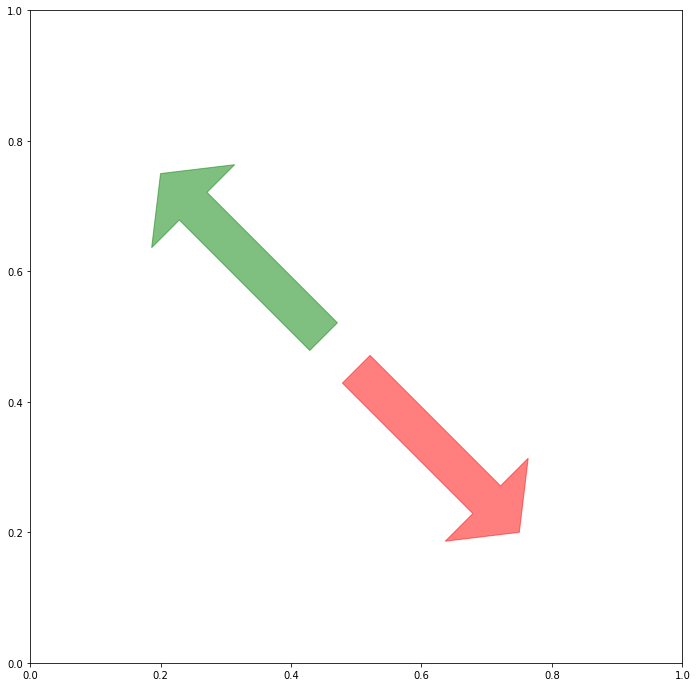

In [38]:
start_time = time.time()


fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(
    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
    )
ax1.add_patch(
    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
    )


n_folds=5
epochs=120
batch_size=128
tprs= []
aucs = []
FPR=[]
mean_fpr = np.linspace(0,1,100)
accur=[]
F1=[]
#save the model history in a list after fitting so that we can plot later
model_history = [] 

sensi=[]
speci=[]
pre=[]
rec=[]
gmean=[]
aupr=[]

mac=[]


for i in range(n_folds):
    print("Training on Fold: ",i+1)
    
    
    X_train, X_test, y_train, y_test= train_test_split(data['SMILES'],data["n_np"],train_size=0.7, test_size=0.3,random_state=i,stratify=data["n_np"])

    train=pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1)
    train= train.reset_index(drop=True)
    test=pd.concat([pd.DataFrame(X_test),pd.DataFrame(y_test)],axis=1)
    test= test.reset_index(drop=True)
    

    data_train=train.append([gene3.iloc[:,2:4]],ignore_index=True)
    
    
    train_mol = data_train["SMILES"].apply(Chem.MolFromSmiles)
    test_mol = test["SMILES"].apply(Chem.MolFromSmiles)
    
    data_train["molimage"] = train_mol.apply(vectorize,embed=21)
    test["molimage"] = test_mol.apply(vectorize,embed=21)   

    input_shape = np.array(list(data_train["molimage"])).shape[1:]

    input_img = Input(shape=input_shape)

    t_x=np.array(list(data_train["molimage"]))
    ex_x=test["molimage"];ex_xx=np.array(list(ex_x));ex_y=test["n_np"]
    
    pooling='max'
    model= EfficientNetB3(input_img,
                   pooling,
                   dropout_rate=0.3)
 
    
    model_history.append(fit_and_evaluate(t_x, data_train.n_np, epochs, batch_size,balanced=True,model_name="efficient"))
    
    
    y_pred = model.predict(ex_xx)
    fpr,tpr,threshold=metrics.roc_curve(ex_y,y_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    cover_fpr =np.where(y_pred>=0.5,1,0)
    F1.append(f1_score(ex_y, cover_fpr))
    accur.append(accuracy_score(ex_y,cover_fpr))
    FPR.append(get_fpr_values(ex_y, cover_fpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    y_test=ex_y; y_pred=cover_fpr
    sen_spe=sensitivity_specificity_support(y_test, y_pred)
    sensi.append(sen_spe[0][0])
    speci.append(sen_spe[0][1])
    pre.append(precision_score(y_test, y_pred, average='macro'))
    rec.append(recall_score(y_test, y_pred, average='macro'))
    gmean.append(geometric_mean_score(y_test, y_pred, average='macro'))
    aupr.append(average_precision_score(y_test,y_pred))
    
    
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    print("Kfold AUC Score: ", aucs)
    print("Kfold Precision Score: ", pre)
    print("Kfold recall Score: ", rec)
    print("Kfold aupr Score: ", aupr)
    print(confusion_matrix(y_test, cover_fpr))
    print("======="*12, end="\n\n\n")

   
   

  
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)



plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1) #0.01

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()
    
    
e = int(time.time() - start_time)
print('{:02d}:{:02d}:{:02d}'.format(e // 3600, (e % 3600 // 60), e % 60))
print("5CV_fp_rate:",np.mean(FPR[0]),np.mean(FPR[1]),np.mean(FPR[2]),np.mean(FPR[3]),np.mean(FPR[4]))

# Inception(Blanced)

In [1]:
start_time = time.time()


fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(
    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
    )
ax1.add_patch(
    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
    )


n_folds=5
epochs=120
batch_size=128
tprs= []
aucs = []
FPR=[]
mean_fpr = np.linspace(0,1,100)
accur=[]
F1=[]
#save the model history in a list after fitting so that we can plot later
model_history = [] 

sensi=[]
speci=[]
pre=[]
rec=[]
gmean=[]
aupr=[]



for i in range(n_folds):
    print("Training on Fold: ",i+1)
    
    
    X_train, X_test, y_train, y_test= train_test_split(data['SMILES'],data["n_np"],train_size=0.7, test_size=0.3,random_state=i,stratify=data["n_np"])

    train=pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1)
    train= train.reset_index(drop=True)
    test=pd.concat([pd.DataFrame(X_test),pd.DataFrame(y_test)],axis=1)
    test= test.reset_index(drop=True)
    

    data_train=train.append([gene3.iloc[:,2:4]],ignore_index=True)
    
    
    train_mol = data_train["SMILES"].apply(Chem.MolFromSmiles)
    test_mol = test["SMILES"].apply(Chem.MolFromSmiles)
    
    data_train["molimage"] = train_mol.apply(vectorize,embed=21)
    test["molimage"] = test_mol.apply(vectorize,embed=21)   

    input_shape = np.array(list(data_train["molimage"])).shape[1:]

    input_img = Input(shape=input_shape)

    t_x=np.array(list(data_train["molimage"]))
    ex_x=test["molimage"];ex_xx=np.array(list(ex_x));ex_y=test["n_np"]
    
    
    x = Inception0(input_img) ## no MaxPooling
    x = Inception(x)
    x = Inception(x)
    od=int(x.shape[1])
    x = MaxPooling2D(pool_size=(od,od), strides=(1,1))(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)  ## aiming at a regression model so using "linear"
 
    model = Model(inputs=input_img, outputs=output)
    
    model_history.append(fit_and_evaluate(t_x, data_train.n_np, epochs, batch_size, balanced=True,model_name="inception"))
    
    
    y_pred = model.predict(ex_xx)
    fpr,tpr,threshold=metrics.roc_curve(ex_y,y_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    cover_fpr =np.where(y_pred>=0.5,1,0)
    F1.append(f1_score(ex_y, cover_fpr))
    accur.append(accuracy_score(ex_y,cover_fpr))
    FPR.append(get_fpr_values(ex_y, cover_fpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    y_test=ex_y; y_pred=cover_fpr
    sen_spe=sensitivity_specificity_support(y_test, y_pred)
    sensi.append(sen_spe[0][0])
    speci.append(sen_spe[0][1])
    pre.append(precision_score(y_test, y_pred, average='macro'))
    rec.append(recall_score(y_test, y_pred, average='macro'))
    gmean.append(geometric_mean_score(y_test, y_pred, average='macro'))
    aupr.append(average_precision_score(y_test,y_pred))
    
    
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    print("Kfold AUC Score: ", aucs)
    print("Kfold Precision Score: ", pre)
    print("Kfold recall Score: ", rec)
    print("Kfold aupr Score: ", aupr)
    print(confusion_matrix(y_test, cover_fpr))
    print("======="*12, end="\n\n\n")

   

  
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)



plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1) #0.01

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()
    
    
e = int(time.time() - start_time)
print('{:02d}:{:02d}:{:02d}'.format(e // 3600, (e % 3600 // 60), e % 60))
print("5CV_fp_rate:",np.mean(FPR[0]),np.mean(FPR[1]),np.mean(FPR[2]),np.mean(FPR[3]),np.mean(FPR[4]))

NameError: name 'time' is not defined

# Efficient-Net(Unbalanced)

Training on Fold:  1

[[119  43]
 [ 28 507]]
Training on Fold:  2
[[112  50]
 [ 31 504]]
Training on Fold:  3
[[119  43]
 [ 33 502]]
Training on Fold:  4
[[102  60]
 [ 37 498]]
Training on Fold:  5
[[111  51]
 [ 18 517]]


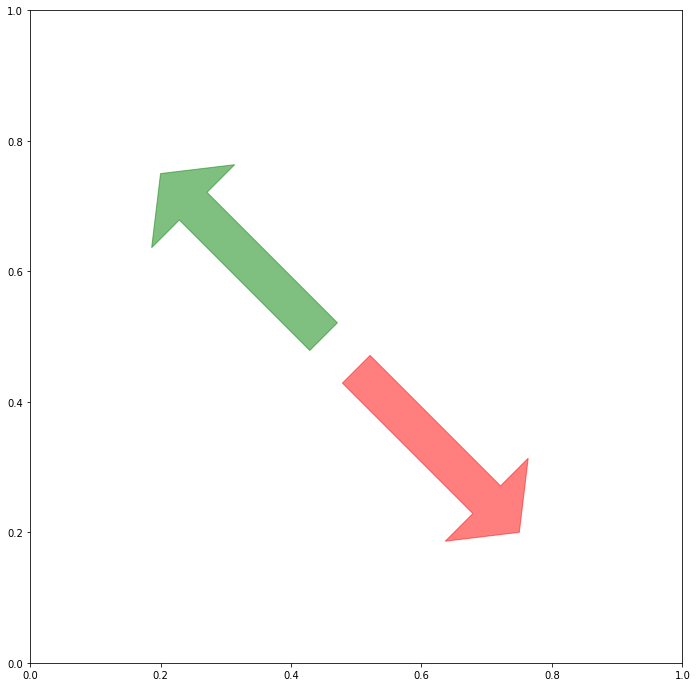

In [24]:
start_time = time.time()


fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(
    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
    )
ax1.add_patch(
    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
    )


n_folds=5
epochs=120
batch_size=128
tprs= []
aucs = []
FPR=[]
mean_fpr = np.linspace(0,1,100)
accur=[]
F1=[]

sensi=[]
speci=[]
pre=[]
rec=[]
gmean=[]
aupr=[]

mac=[]

bal_acc=[]
kappa=[]
TNR=[]
TPR=[]

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    
    
    X_train, X_test, y_train, y_test= train_test_split(data['SMILES'],data["n_np"],train_size=0.7, test_size=0.3,random_state=i,stratify=data["n_np"])

    train=pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1)
    train= train.reset_index(drop=True)
    test=pd.concat([pd.DataFrame(X_test),pd.DataFrame(y_test)],axis=1)
    test= test.reset_index(drop=True)
    
    
    

    train_mol = train["SMILES"].apply(Chem.MolFromSmiles)
    test_mol = test["SMILES"].apply(Chem.MolFromSmiles)

    train["molimage"] = train_mol.apply(vectorize,embed=21)
    test["molimage"] = test_mol.apply(vectorize,embed=21)   

    input_shape = np.array(list(train["molimage"])).shape[1:]



    t_x=np.array(list(train["molimage"]))
    ex_x=test["molimage"];ex_xx=np.array(list(ex_x));ex_y=test["n_np"]

    pooling='max'

    model =  EfficientNetB3(input_shape,
                       pooling,
                       dropout_rate=0.3)

    model_history.append(fit_and_evaluate(t_x, data_train.n_np, epochs, batch_size,balanced=False,model_name="efficient"))    
    y_pred = model.predict(ex_xx)
    y_test=ex_y
    aupr.append(average_precision_score(y_test,y_pred))
    aucs.append(roc_auc_score(y_test, y_pred))
    fpr,tpr,threshold=metrics.roc_curve(y_test,y_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    cover_fpr =np.where(y_pred>=0.5,1,0)
    cm = confusion_matrix(y_test,  cover_fpr )
    FPR.append(get_fpr_values(y_test, cover_fpr))
    TPR.append(get_tpr_values(y_test, cover_fpr))
    TNR.append(get_tnr_values(y_test, cover_fpr))
    F1.append(f1_score(y_test, cover_fpr,average='weighted'))
    accur.append(accuracy_score(y_test,cover_fpr))
    sen_spe=sensitivity_specificity_support(y_test,cover_fpr)
    sensi.append(sen_spe[0][0])
    speci.append(sen_spe[0][1])
    pre.append(precision_score(y_test, cover_fpr, average='weighted'))
    rec.append(recall_score(y_test, cover_fpr, average='weighted'))
    gmean.append(geometric_mean_score(y_test, cover_fpr,average='weighted'))
    mac.append(matthews_corrcoef(y_test, cover_fpr))
    bal_acc.append(balanced_accuracy_score(y_test,cover_fpr))
    kappa.append(cohen_kappa_score(y_test,cover_fpr))
    print(cm)
    



# Inception(Unbalanced)

In [ ]:
start_time = time.time()


fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(
    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
    )
ax1.add_patch(
    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
    )

n_folds=5
epochs=120
batch_size=128
tprs = []
aucs = []

sensi=[]
speci=[]
pre=[]
rec=[]
gmean=[]
aupr=[]



accur=[]
F1=[]
FPR=[]
mean_fpr = np.linspace(0,1,100)

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(data["molimage"],n_np, test_size=0.3,  stratify=n_np,
                                               random_state =i)
    t_x=np.array(list(t_x))
    val_x=np.array(list(val_x))
    input_img = Input(shape=input_shape)
 
    x = Inception0(input_img) ## no MaxPooling
    x = Inception(x)
    x = Inception(x)
    od=int(x.shape[1])
    x = MaxPooling2D(pool_size=(od,od), strides=(1,1))(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)  ## aiming at a regression model so using "linear"
 
    model = Model(inputs=input_img, outputs=output)
    
    model_history.append(fit_and_evaluate(t_x,  t_y,  epochs, batch_size,,balanced=False,model_name="inception"))
    
    y_pred = model.predict(val_x)
    fpr,tpr,threshold=metrics.roc_curve(val_y,y_pred)
    cover_fpr =np.where(y_pred>=0.5,1,0) 
    y_pred=cover_fpr; y_test=val_y
    sen_spe=sensitivity_specificity_support(y_test, y_pred)
    fpr, tpr, t = roc_curve(y_test,  y_pred)
    
    sen_spe=sensitivity_specificity_support(y_test, y_pred)
    sensi.append(sen_spe[0][0])
    speci.append(sen_spe[0][1])
    pre.append(precision_score(y_test, y_pred, average='macro'))
    rec.append(recall_score(y_test, y_pred, average='macro'))
    gmean.append(geometric_mean_score(y_test, y_pred, average='macro'))
    aupr.append(average_precision_score(y_test,y_pred))
    
    
    
   
    tprs.append(interp(mean_fpr, fpr, tpr))
    FPR.append(get_fpr_values(val_y, cover_fpr))
    F1.append(f1_score(val_y, cover_fpr))
    accur.append(accuracy_score(val_y,cover_fpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    #model.save( "./model_checkpoint/bbb_unbal_inception_" + str(i) + "_weights.h5")
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    print("Kfold AUC Score: ", aucs)
    print("Kfold Precision Score: ", pre)
    print("Kfold recall Score: ", rec)
    print("Kfold aupr Score: ", aupr)
    print(confusion_matrix(y_test, cover_fpr))
    print("======="*12, end="\n\n\n")

    

  
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()
    
    
e = int(time.time() - start_time)
print('{:02d}:{:02d}:{:02d}'.format(e // 3600, (e % 3600 // 60), e % 60))
print("5CV_fp_rate:",FPR[0],FPR[1],FPR[2],FPR[3],FPR[4])

# RandomForest

In [8]:
data.n_np = np.where(data.n_np==0,1,0)
data.n_np.value_counts()

0    1782
1     539
Name: n_np, dtype: int64

In [9]:
b= []
for i in range(0,len(data)):
    try:
        Chem.MolToSmiles(remover.StripMol(Chem.MolFromSmiles(remove_nonbonded(data['SMILES'][i]))))
    except:
        b.append(i)
        print(i)
        pass

In [10]:
b

[]

In [11]:
data = data.drop(data.index[b])
data = data.reset_index(drop=True)

In [12]:
data['CANONICAL_SMILES']= (data['SMILES'].apply(remove_nonbonded).apply(Chem.MolFromSmiles).apply(remover.StripMol).apply(Chem.MolToSmiles))

for i in range(data.shape[0]):
    if len(data.iloc[i,2]) == 0:
        data.iloc[i,2] = data.iloc[i,0]

# Make Fingerprint

In [13]:
fingerprint_2048 = data["CANONICAL_SMILES"].apply(smiles_to_finger,radian=2,nBits=2048)
fingerprint_2048 = pd.DataFrame(fingerprint_2048.to_list(),index=fingerprint_2048.index)

In [14]:
data_2048 = pd.concat([data,fingerprint_2048],axis=1)

In [15]:
acc = []
f_score = []
g_mean = []
auc = []
auprc = []
tpr = []
tnr = []
bal_acc = []
for i in tqdm_notebook(range(5)):
    X_train, X_test, y_train, y_test= train_test_split(data_2048.iloc[:,3:],data_2048["n_np"],
                                                       train_size=0.7, test_size=0.3,random_state=i,
                                                       stratify=data_2048["n_np"])
    rf = RandomForestClassifier(random_state=i)
    rf.fit(X_train,y_train)
    predicted = rf.predict(X_test)
    pred_proba = rf.predict_proba(X_test)[:,1]
    acc.append(accuracy_score(y_test,predicted))
    f_score.append(f1_score(y_test,predicted))
    g_mean.append(gmean_score(y_test,predicted))
    auc.append(roc_auc_score(y_test, pred_proba))
    auprc.append(average_precision_score(y_test,pred_proba))
    tn,fp,fn,tp = confusion_matrix(y_test,predicted).ravel()
    tpr.append(tp/(tp+fn))
    tnr.append(tn/(tn+fp))
    bal_acc.append(balanced_accuracy_score(y_test, predicted))
    print(confusion_matrix(y_test,predicted))





[[526   9]
 [ 45 117]]
[[524  11]
 [ 57 105]]
[[525  10]
 [ 48 114]]
[[527   8]
 [ 53 109]]
[[524  11]
 [ 59 103]]



In [16]:
print("acc")
print(np.round(acc,4))
print(np.round(np.mean(acc),4),np.round(np.std(acc),4))
print("f_score")
print(np.round(f_score,4))
print(np.round(np.mean(f_score),4),np.round(np.std(f_score),4))
print("g_mean")
print(np.round(g_mean,4))
print(np.round(np.mean(g_mean),4),np.round(np.std(g_mean),4))
print("auc")
print(np.round(auc,4))
print(np.round(np.mean(auc),4),np.round(np.std(auc),4))
print("auprc")
print(np.round(auprc,4))
print(np.round(np.mean(auprc),4),np.round(np.std(auprc),4))
print("tpr")
print(np.round(tpr,4))
print(np.round(np.mean(tpr),4),np.round(np.std(tpr),4))
print("tnr")
print(np.round(tnr,4))
print(np.round(np.mean(tnr),4),np.round(np.std(tnr),4))
print("Balanced_accuracy")
print(np.round(bal_acc,4))
print(np.round(np.mean(bal_acc),4),np.round(np.std(bal_acc),4))

acc
[0.9225 0.9024 0.9168 0.9125 0.8996]
0.9108 0.0086
f_score
[0.8125 0.7554 0.7972 0.7814 0.7464]
0.7786 0.0248
g_mean
[0.8427 0.7968 0.831  0.8141 0.7891]
0.8147 0.0201
auc
[0.9533 0.9486 0.937  0.9506 0.9252]
0.9429 0.0105
auprc
[0.8972 0.8706 0.8878 0.8897 0.8493]
0.8789 0.0172
tpr
[0.7222 0.6481 0.7037 0.6728 0.6358]
0.6765 0.0326
tnr
[0.9832 0.9794 0.9813 0.985  0.9794]
0.9817 0.0022
Balanced_accuracy
[0.8527 0.8138 0.8425 0.8289 0.8076]
0.8291 0.0169


# SMOTE

In [17]:
acc = []
f_score = []
g_mean = []
auc = []
auprc = []
tpr = []
tnr = []
bal_acc = []
for i in tqdm_notebook(range(5)):
    X_train, X_test, y_train, y_test= train_test_split(data_2048.iloc[:,3:],data_2048["n_np"],
                                                       train_size=0.7, test_size=0.3,random_state=i,
                                                       stratify=data_2048["n_np"])
    
    sm = SMOTE(random_state=i)
    X_resampled, y_resampled = sm.fit_sample(X_train,y_train)
    rf = RandomForestClassifier(random_state=i)
    rf.fit(X_resampled,y_resampled)
    predicted = rf.predict(X_test)
    pred_proba = rf.predict_proba(X_test)[:,1]
    acc.append(accuracy_score(y_test,predicted))
    f_score.append(f1_score(y_test,predicted))
    g_mean.append(gmean_score(y_test,predicted))
    auc.append(roc_auc_score(y_test, pred_proba))
    auprc.append(average_precision_score(y_test,pred_proba))
    tn,fp,fn,tp = confusion_matrix(y_test,predicted).ravel()
    tpr.append(tp/(tp+fn))
    tnr.append(tn/(tn+fp))
    bal_acc.append(balanced_accuracy_score(y_test, predicted))
    print(confusion_matrix(y_test,predicted))





[[526   9]
 [ 45 117]]
[[523  12]
 [ 49 113]]
[[524  11]
 [ 44 118]]
[[525  10]
 [ 45 117]]
[[523  12]
 [ 49 113]]



In [18]:
print("acc")
print(np.round(acc,4))
print(np.round(np.mean(acc),4),np.round(np.std(acc),4))
print("f_score")
print(np.round(f_score,4))
print(np.round(np.mean(f_score),4),np.round(np.std(f_score),4))
print("g_mean")
print(np.round(g_mean,4))
print(np.round(np.mean(g_mean),4),np.round(np.std(g_mean),4))
print("auc")
print(np.round(auc,4))
print(np.round(np.mean(auc),4),np.round(np.std(auc),4))
print("auprc")
print(np.round(auprc,4))
print(np.round(np.mean(auprc),4),np.round(np.std(auprc),4))
print("tpr")
print(np.round(tpr,4))
print(np.round(np.mean(tpr),4),np.round(np.std(tpr),4))
print("tnr")
print(np.round(tnr,4))
print(np.round(np.mean(tnr),4),np.round(np.std(tnr),4))
print("Balanced_accuracy")
print(np.round(bal_acc,4))
print(np.round(np.mean(bal_acc),4),np.round(np.std(bal_acc),4))

acc
[0.9225 0.9125 0.9211 0.9211 0.9125]
0.9179 0.0045
f_score
[0.8125 0.7875 0.811  0.8097 0.7875]
0.8016 0.0116
g_mean
[0.8427 0.8258 0.8446 0.8419 0.8258]
0.8361 0.0085
auc
[0.9517 0.9508 0.9386 0.9502 0.9306]
0.9444 0.0084
auprc
[0.8821 0.8647 0.8897 0.889  0.8704]
0.8792 0.01
tpr
[0.7222 0.6975 0.7284 0.7222 0.6975]
0.7136 0.0133
tnr
[0.9832 0.9776 0.9794 0.9813 0.9776]
0.9798 0.0022
Balanced_accuracy
[0.8527 0.8376 0.8539 0.8518 0.8376]
0.8467 0.0075


# SMOTE ENN

In [19]:
acc = []
f_score = []
g_mean = []
auc = []
auprc = []
tpr = []
tnr = []
bal_acc = []
for i in tqdm_notebook(range(5)):
    X_train, X_test, y_train, y_test= train_test_split(data_2048.iloc[:,3:],data_2048["n_np"],
                                                       train_size=0.7, test_size=0.3,random_state=i,
                                                       stratify=data_2048["n_np"])
    
    sm = SMOTEENN(random_state=i)
    X_resampled, y_resampled = sm.fit_sample(X_train,y_train)
    rf = RandomForestClassifier(random_state=i)
    rf.fit(X_resampled,y_resampled)
    predicted = rf.predict(X_test)
    pred_proba = rf.predict_proba(X_test)[:,1]
    acc.append(accuracy_score(y_test,predicted))
    f_score.append(f1_score(y_test,predicted))
    g_mean.append(gmean_score(y_test,predicted))
    auc.append(roc_auc_score(y_test, pred_proba))
    auprc.append(average_precision_score(y_test,pred_proba))
    tn,fp,fn,tp = confusion_matrix(y_test,predicted).ravel()
    tpr.append(tp/(tp+fn))
    tnr.append(tn/(tn+fp))
    bal_acc.append(balanced_accuracy_score(y_test, predicted))
    print(confusion_matrix(y_test,predicted))





[[501  34]
 [ 38 124]]
[[489  46]
 [ 31 131]]
[[493  42]
 [ 37 125]]
[[505  30]
 [ 29 133]]
[[497  38]
 [ 35 127]]



In [20]:
print("acc")
print(np.round(acc,4))
print(np.round(np.mean(acc),4),np.round(np.std(acc),4))
print("f_score")
print(np.round(f_score,4))
print(np.round(np.mean(f_score),4),np.round(np.std(f_score),4))
print("g_mean")
print(np.round(g_mean,4))
print(np.round(np.mean(g_mean),4),np.round(np.std(g_mean),4))
print("auc")
print(np.round(auc,4))
print(np.round(np.mean(auc),4),np.round(np.std(auc),4))
print("auprc")
print(np.round(auprc,4))
print(np.round(np.mean(auprc),4),np.round(np.std(auprc),4))
print("tpr")
print(np.round(tpr,4))
print(np.round(np.mean(tpr),4),np.round(np.std(tpr),4))
print("tnr")
print(np.round(tnr,4))
print(np.round(np.mean(tnr),4),np.round(np.std(tnr),4))
print("Balanced_accuracy")
print(np.round(bal_acc,4))
print(np.round(np.mean(bal_acc),4),np.round(np.std(bal_acc),4))

acc
[0.8967 0.8895 0.8867 0.9154 0.8953]
0.8967 0.01
f_score
[0.775  0.7729 0.7599 0.8185 0.7768]
0.7806 0.0198
g_mean
[0.8466 0.8597 0.8432 0.8803 0.8534]
0.8567 0.0131
auc
[0.9445 0.944  0.9159 0.9478 0.9216]
0.9347 0.0132
auprc
[0.8732 0.8451 0.8531 0.8792 0.845 ]
0.8591 0.0144
tpr
[0.7654 0.8086 0.7716 0.821  0.784 ]
0.7901 0.0214
tnr
[0.9364 0.914  0.9215 0.9439 0.929 ]
0.929 0.0106
Balanced_accuracy
[0.8509 0.8613 0.8466 0.8825 0.8565]
0.8595 0.0125


# Make Descriptor

In [21]:
name = [
    'MolWt',
    'HeavyAtomMolWt',
    'ExactMolWt',
    'NumValenceElectrons',
    'NumRadicalElectrons',
    'MaxEStateIndex',
    'MinEStateIndex',
    'MaxAbsEStateIndex',
    'MinAbsEStateIndex',
    'BalabanJ',
    'BertzCT',
    'Chi0',
    'Chi0n',
    'Chi0v',
    'Chi1',
    'Chi1n',
    'Chi1v',
    'Chi2n',
    'Chi2v',
    'Chi3n',
    'Chi3v',
    'Chi4n',
    'Chi4v',
    'EState_VSA1',
    'EState_VSA10',
    'EState_VSA11',
    'EState_VSA2',
    'EState_VSA3',
    'EState_VSA4',
    'EState_VSA5',
    'EState_VSA6',
    'EState_VSA7',
    'EState_VSA8',
    'EState_VSA9',
    'FractionCSP3',
    'HallKierAlpha',
    'HeavyAtomCount',
    'Ipc',
    'Kappa1',
    'Kappa2',
    'Kappa3',
    'LabuteASA',
    'MolLogP',
    'MolMR',
    'NHOHCount',
    'NOCount',
    'NumAliphaticCarbocycles',
    'NumAliphaticHeterocycles',
    'NumAliphaticRings',
    'NumAromaticCarbocycles',
    'NumAromaticHeterocycles',
    'NumAromaticRings',
    'NumHAcceptors',
    'NumHDonors',
    'NumHeteroatoms',
    'NumRotatableBonds',
    'NumSaturatedCarbocycles',
    'NumSaturatedHeterocycles',
    'NumSaturatedRings',
    'PEOE_VSA1',
    'PEOE_VSA10',
    'PEOE_VSA11',
    'PEOE_VSA12',
    'PEOE_VSA13',
    'PEOE_VSA14',
    'PEOE_VSA2',
    'PEOE_VSA3',
    'PEOE_VSA4',
    'PEOE_VSA5',
    'PEOE_VSA6',
    'PEOE_VSA7',
    'PEOE_VSA8',
    'PEOE_VSA9',
    'RingCount',
    'SMR_VSA1',
    'SMR_VSA10',
    'SMR_VSA2',
    'SMR_VSA3',
    'SMR_VSA4',
    'SMR_VSA5',
    'SMR_VSA6',
    'SMR_VSA7',
    'SMR_VSA8',
    'SMR_VSA9',
    'SlogP_VSA1',
    'SlogP_VSA10',
    'SlogP_VSA11',
    'SlogP_VSA12',
    'SlogP_VSA2',
    'SlogP_VSA3',
    'SlogP_VSA4',
    'SlogP_VSA5',
    'SlogP_VSA6',
    'SlogP_VSA7',
    'SlogP_VSA8',
    'SlogP_VSA9',
    'TPSA',
    'VSA_EState1',
    'VSA_EState10',
    'VSA_EState2',
    'VSA_EState3',
    'VSA_EState4',
    'VSA_EState5',
    'VSA_EState6',
    'VSA_EState7',
    'VSA_EState8',
    'VSA_EState9',
    'fr_Al_COO',
    'fr_Al_OH',
    'fr_Al_OH_noTert',
    'fr_ArN',
    'fr_Ar_COO',
    'fr_Ar_N',
    'fr_Ar_NH',
    'fr_Ar_OH',
    'fr_COO',
    'fr_COO2',
    'fr_C_O',
    'fr_C_O_noCOO',
    'fr_C_S',
    'fr_HOCCN',
    'fr_Imine',
    'fr_NH0',
    'fr_NH1',
    'fr_NH2',
    'fr_N_O',
    'fr_Ndealkylation1',
    'fr_Ndealkylation2',
    'fr_Nhpyrrole',
    'fr_SH',
    'fr_aldehyde',
    'fr_alkyl_carbamate',
    'fr_alkyl_halide',
    'fr_allylic_oxid',
    'fr_amide',
    'fr_amidine',
    'fr_aniline',
    'fr_aryl_methyl',
    'fr_azide',
    'fr_azo',
    'fr_barbitur',
    'fr_benzene',
    'fr_benzodiazepine',
    'fr_bicyclic',
    'fr_diazo',
    'fr_dihydropyridine',
    'fr_epoxide',
    'fr_ester',
    'fr_ether',
    'fr_furan',
    'fr_guanido',
    'fr_halogen',
    'fr_hdrzine',
    'fr_hdrzone',
    'fr_imidazole',
    'fr_imide',
    'fr_isocyan',
    'fr_isothiocyan',
    'fr_ketone',
    'fr_ketone_Topliss',
    'fr_lactam',
    'fr_lactone',
    'fr_methoxy',
    'fr_morpholine',
    'fr_nitrile',
    'fr_nitro',
    'fr_nitro_arom',
    'fr_nitro_arom_nonortho',
    'fr_nitroso',
    'fr_oxazole',
    'fr_oxime',
    'fr_para_hydroxylation',
    'fr_phenol',
    'fr_phenol_noOrthoHbond',
    'fr_phos_acid',
    'fr_phos_ester',
    'fr_piperdine',
    'fr_piperzine',
    'fr_priamide',
    'fr_prisulfonamd',
    'fr_pyridine',
    'fr_quatN',
    'fr_sulfide',
    'fr_sulfonamd',
    'fr_sulfone',
    'fr_term_acetylene',
    'fr_tetrazole',
    'fr_thiazole',
    'fr_thiocyan',
    'fr_thiophene',
    'fr_unbrch_alkane',
    'fr_urea',
    'MaxAbsPartialCharge',
    'MaxPartialCharge',
    'MinAbsPartialCharge',
    'MinPartialCharge'
]

function = [
    Descriptors.MolWt,
    Descriptors.HeavyAtomMolWt,
    Descriptors.ExactMolWt,
    Descriptors.NumValenceElectrons,
    Descriptors.NumRadicalElectrons,
    # http://www.rdkit.org/docs/api/rdkit.Chem.Descriptors-module.html
    Descriptors.MaxEStateIndex,
    Descriptors.MinEStateIndex,
    Descriptors.MaxAbsEStateIndex,
    Descriptors.MinAbsEStateIndex,
    Descriptors.BalabanJ,
    Descriptors.BertzCT,
    Descriptors.Chi0,
    Descriptors.Chi0n,
    Descriptors.Chi0v,
    Descriptors.Chi1,
    Descriptors.Chi1n,
    Descriptors.Chi1v,
    Descriptors.Chi2n,
    Descriptors.Chi2v,
    Descriptors.Chi3n,
    Descriptors.Chi3v,
    Descriptors.Chi4n,
    Descriptors.Chi4v,
    Descriptors.EState_VSA1,
    Descriptors.EState_VSA10,
    Descriptors.EState_VSA11,
    Descriptors.EState_VSA2,
    Descriptors.EState_VSA3,
    Descriptors.EState_VSA4,
    Descriptors.EState_VSA5,
    Descriptors.EState_VSA6,
    Descriptors.EState_VSA7,
    Descriptors.EState_VSA8,
    Descriptors.EState_VSA9,
    Descriptors.FractionCSP3,
    Descriptors.HallKierAlpha,
    Descriptors.HeavyAtomCount,
    Descriptors.Ipc,
    Descriptors.Kappa1,
    Descriptors.Kappa2,
    Descriptors.Kappa3,
    Descriptors.LabuteASA,
    Descriptors.MolLogP,
    Descriptors.MolMR,
    Descriptors.NHOHCount,
    Descriptors.NOCount,
    Descriptors.NumAliphaticCarbocycles,
    Descriptors.NumAliphaticHeterocycles,
    Descriptors.NumAliphaticRings,
    Descriptors.NumAromaticCarbocycles,
    Descriptors.NumAromaticHeterocycles,
    Descriptors.NumAromaticRings,
    Descriptors.NumHAcceptors,
    Descriptors.NumHDonors,
    Descriptors.NumHeteroatoms,
    Descriptors.NumRotatableBonds,
    Descriptors.NumSaturatedCarbocycles,
    Descriptors.NumSaturatedHeterocycles,
    Descriptors.NumSaturatedRings,
    Descriptors.PEOE_VSA1,
    Descriptors.PEOE_VSA10,
    Descriptors.PEOE_VSA11,
    Descriptors.PEOE_VSA12,
    Descriptors.PEOE_VSA13,
    Descriptors.PEOE_VSA14,
    Descriptors.PEOE_VSA2,
    Descriptors.PEOE_VSA3,
    Descriptors.PEOE_VSA4,
    Descriptors.PEOE_VSA5,
    Descriptors.PEOE_VSA6,
    Descriptors.PEOE_VSA7,
    Descriptors.PEOE_VSA8,
    Descriptors.PEOE_VSA9,
    Descriptors.RingCount,
    Descriptors.SMR_VSA1,
    Descriptors.SMR_VSA10,
    Descriptors.SMR_VSA2,
    Descriptors.SMR_VSA3,
    Descriptors.SMR_VSA4,
    Descriptors.SMR_VSA5,
    Descriptors.SMR_VSA6,
    Descriptors.SMR_VSA7,
    Descriptors.SMR_VSA8,
    Descriptors.SMR_VSA9,
    Descriptors.SlogP_VSA1,
    Descriptors.SlogP_VSA10,
    Descriptors.SlogP_VSA11,
    Descriptors.SlogP_VSA12,
    Descriptors.SlogP_VSA2,
    Descriptors.SlogP_VSA3,
    Descriptors.SlogP_VSA4,
    Descriptors.SlogP_VSA5,
    Descriptors.SlogP_VSA6,
    Descriptors.SlogP_VSA7,
    Descriptors.SlogP_VSA8,
    Descriptors.SlogP_VSA9,
    Descriptors.TPSA,
    Descriptors.VSA_EState1,
    Descriptors.VSA_EState10,
    Descriptors.VSA_EState2,
    Descriptors.VSA_EState3,
    Descriptors.VSA_EState4,
    Descriptors.VSA_EState5,
    Descriptors.VSA_EState6,
    Descriptors.VSA_EState7,
    Descriptors.VSA_EState8,
    Descriptors.VSA_EState9,
    Descriptors.fr_Al_COO,
    Descriptors.fr_Al_OH,
    Descriptors.fr_Al_OH_noTert,
    Descriptors.fr_ArN,
    Descriptors.fr_Ar_COO,
    Descriptors.fr_Ar_N,
    Descriptors.fr_Ar_NH,
    Descriptors.fr_Ar_OH,
    Descriptors.fr_COO,
    Descriptors.fr_COO2,
    Descriptors.fr_C_O,
    Descriptors.fr_C_O_noCOO,
    Descriptors.fr_C_S,
    Descriptors.fr_HOCCN,
    Descriptors.fr_Imine,
    Descriptors.fr_NH0,
    Descriptors.fr_NH1,
    Descriptors.fr_NH2,
    Descriptors.fr_N_O,
    Descriptors.fr_Ndealkylation1,
    Descriptors.fr_Ndealkylation2,
    Descriptors.fr_Nhpyrrole,
    Descriptors.fr_SH,
    Descriptors.fr_aldehyde,
    Descriptors.fr_alkyl_carbamate,
    Descriptors.fr_alkyl_halide,
    Descriptors.fr_allylic_oxid,
    Descriptors.fr_amide,
    Descriptors.fr_amidine,
    Descriptors.fr_aniline,
    Descriptors.fr_aryl_methyl,
    Descriptors.fr_azide,
    Descriptors.fr_azo,
    Descriptors.fr_barbitur,
    Descriptors.fr_benzene,
    Descriptors.fr_benzodiazepine,
    Descriptors.fr_bicyclic,
    Descriptors.fr_diazo,
    Descriptors.fr_dihydropyridine,
    Descriptors.fr_epoxide,
    Descriptors.fr_ester,
    Descriptors.fr_ether,
    Descriptors.fr_furan,
    Descriptors.fr_guanido,
    Descriptors.fr_halogen,
    Descriptors.fr_hdrzine,
    Descriptors.fr_hdrzone,
    Descriptors.fr_imidazole,
    Descriptors.fr_imide,
    Descriptors.fr_isocyan,
    Descriptors.fr_isothiocyan,
    Descriptors.fr_ketone,
    Descriptors.fr_ketone_Topliss,
    Descriptors.fr_lactam,
    Descriptors.fr_lactone,
    Descriptors.fr_methoxy,
    Descriptors.fr_morpholine,
    Descriptors.fr_nitrile,
    Descriptors.fr_nitro,
    Descriptors.fr_nitro_arom,
    Descriptors.fr_nitro_arom_nonortho,
    Descriptors.fr_nitroso,
    Descriptors.fr_oxazole,
    Descriptors.fr_oxime,
    Descriptors.fr_para_hydroxylation,
    Descriptors.fr_phenol,
    Descriptors.fr_phenol_noOrthoHbond,
    Descriptors.fr_phos_acid,
    Descriptors.fr_phos_ester,
    Descriptors.fr_piperdine,
    Descriptors.fr_piperzine,
    Descriptors.fr_priamide,
    Descriptors.fr_prisulfonamd,
    Descriptors.fr_pyridine,
    Descriptors.fr_quatN,
    Descriptors.fr_sulfide,
    Descriptors.fr_sulfonamd,
    Descriptors.fr_sulfone,
    Descriptors.fr_term_acetylene,
    Descriptors.fr_tetrazole,
    Descriptors.fr_thiazole,
    Descriptors.fr_thiocyan,
    Descriptors.fr_thiophene,
    Descriptors.fr_unbrch_alkane,
    Descriptors.fr_urea,
    Descriptors.MaxAbsPartialCharge,
    Descriptors.MaxPartialCharge,
    Descriptors.MinAbsPartialCharge,
    Descriptors.MinPartialCharge
]

In [22]:
data_descriptor = data.copy()
data_descriptor['Mol'] = data_descriptor['CANONICAL_SMILES'].apply(Chem.MolFromSmiles)
for i in range(len(name)):
    #print(i)
    data_descriptor[name[i]] = data_descriptor['Mol'].apply(function[i]) #함수적용 
    
data_descriptor = data_descriptor.drop(['Mol'],axis=1)

In [23]:
data_descriptor

,SMILES,n_np,CANONICAL_SMILES,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxEStateIndex,MinEStateIndex,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,MaxAbsPartialCharge,MaxPartialCharge,MinAbsPartialCharge,MinPartialCharge
0,Brc1cccc(c1N=C1NCCN1)Br,0,Brc1cccc(Br)c1N=C1NCCN1,319.000,309.928,316.916321,74,0,4.457824,0.831111,...,0,0,0,0,0,0,0.354321,0.196202,0.196202,-0.354321
1,Brc1cc(Br)cc(c1N=C1NCCN1)Br,0,Brc1cc(Br)c(N=C2NCCN2)c(Br)c1,397.896,389.832,394.826834,80,0,4.478102,0.818262,...,0,0,0,0,0,0,0.354321,0.196202,0.196202,-0.354321
2,O=c1c(Br)ccc2n1C[C@@H]1CNC[C@@H]2C1,0,O=c1c(Br)ccc2n1C[C@@H]1CNC[C@@H]2C1,269.142,256.038,268.021125,80,0,11.940193,0.128796,...,0,0,0,0,0,0,0.315723,0.264563,0.264563,-0.315723
3,Cc1ccc(cc1)C,0,Cc1ccc(C)cc1,106.168,96.088,106.078250,42,0,2.120370,1.329259,...,0,0,0,0,0,0,0.059063,-0.039774,0.039774,-0.059063
4,Cc1ccccc1C,0,Cc1ccccc1C,106.168,96.088,106.078250,42,0,2.120370,1.368056,...,0,0,0,0,0,0,0.061985,-0.039511,0.039511,-0.061985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2316,CO[C@H]1CCC[C@H]2C1=C(C=O)N1[C@@H]2C(C1=O)[C@@...,1,CO[C@H]1CCC[C@H]2C1=C(C=O)N1C(=O)C([C@H](C)O)[...,265.309,246.157,265.131408,104,0,12.124414,-0.663034,...,0,0,0,0,0,0,0.392506,0.234736,0.234736,-0.392506
2317,CC/C(=C(/c1ccccc1)\c1ccc(cc1)OCCN(C)C)/c1ccccc1,1,CC/C(=C(/c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1,371.524,342.292,371.224915,144,0,5.870988,0.692414,...,0,0,0,0,0,0,0.492264,0.118903,0.118903,-0.492264
2318,COC1(NC(=O)[C@H](c2cscc2)C(=O)O)C(=O)N2[C@H]1S...,1,COC1(NC(=O)[C@@H](C(=O)O)c2ccsc2)C(=O)N2[C@@H]...,414.461,396.317,414.055543,146,0,12.777484,-1.798669,...,0,0,0,1,0,0,0.480398,0.327404,0.327404,-0.480398
2319,CN([C@@H]1C(=C(C(=O)N)C(=O)C2([C@H]1C[C@H]1C(=...,1,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)C2(O)C(O)=C3C(=...,444.440,420.248,444.153266,170,0,13.313695,-2.745034,...,0,0,0,0,0,0,0.509651,0.255451,0.255451,-0.509651


# Run BaseModel

In [24]:
acc = []
f_score = []
g_mean = []
auc = []
auprc = []
tpr = []
tnr = []
bal_acc = []
for i in tqdm_notebook(range(5)):
    X_train, X_test, y_train, y_test= train_test_split(data_descriptor.iloc[:,3:],data_descriptor["n_np"],
                                                       train_size=0.7, test_size=0.3,random_state=i,
                                                       stratify=data_descriptor["n_np"])
    
    rf = RandomForestClassifier(n_estimators=100,random_state=i)
    rf.fit(X_train,y_train)
    predicted = rf.predict(X_test)
    pred_proba = rf.predict_proba(X_test)[:,1]
    acc.append(accuracy_score(y_test,predicted))
    f_score.append(f1_score(y_test,predicted))
    g_mean.append(gmean_score(y_test,predicted))
    auc.append(roc_auc_score(y_test, pred_proba))
    auprc.append(average_precision_score(y_test,pred_proba))
    tn,fp,fn,tp = confusion_matrix(y_test,predicted).ravel()
    tpr.append(tp/(tp+fn))
    tnr.append(tn/(tn+fp))
    bal_acc.append(balanced_accuracy_score(y_test, predicted))
    print(confusion_matrix(y_test,predicted))






[[522  13]
 [ 40 122]]
[[526   9]
 [ 46 116]]
[[526   9]
 [ 51 111]]
[[522  13]
 [ 51 111]]
[[522  13]
 [ 55 107]]



In [25]:
print("acc")
print(np.round(acc,4))
print(np.round(np.mean(acc),4),np.round(np.std(acc),4))
print("f_score")
print(np.round(f_score,4))
print(np.round(np.mean(f_score),4),np.round(np.std(f_score),4))
print("g_mean")
print(np.round(g_mean,4))
print(np.round(np.mean(g_mean),4),np.round(np.std(g_mean),4))
print("auc")
print(np.round(auc,4))
print(np.round(np.mean(auc),4),np.round(np.std(auc),4))
print("auprc")
print(np.round(auprc,4))
print(np.round(np.mean(auprc),4),np.round(np.std(auprc),4))
print("tpr")
print(np.round(tpr,4))
print(np.round(np.mean(tpr),4),np.round(np.std(tpr),4))
print("tnr")
print(np.round(tnr,4))
print(np.round(np.mean(tnr),4),np.round(np.std(tnr),4))
print("Balanced_accuracy")
print(np.round(bal_acc,4))
print(np.round(np.mean(bal_acc),4),np.round(np.std(bal_acc),4))

acc
[0.924  0.9211 0.9139 0.9082 0.9024]
0.9139 0.008
f_score
[0.8215 0.8084 0.7872 0.7762 0.7589]
0.7904 0.0224
g_mean
[0.8572 0.839  0.8208 0.8176 0.8028]
0.8275 0.0188
auc
[0.9633 0.9621 0.945  0.9559 0.9334]
0.9519 0.0113
auprc
[0.909  0.8983 0.8999 0.8881 0.8797]
0.895 0.0101
tpr
[0.7531 0.716  0.6852 0.6852 0.6605]
0.7 0.0319
tnr
[0.9757 0.9832 0.9832 0.9757 0.9757]
0.9787 0.0037
Balanced_accuracy
[0.8644 0.8496 0.8342 0.8304 0.8181]
0.8393 0.0161


# SMOTE

In [26]:
acc = []
f_score = []
g_mean = []
auc = []
auprc = []
tpr = []
tnr = []
bal_acc = []
for i in tqdm_notebook(range(5)):
    X_train, X_test, y_train, y_test= train_test_split(data_descriptor.iloc[:,3:],data_descriptor["n_np"],
                                                       train_size=0.7, test_size=0.3,random_state=i,
                                                       stratify=data_descriptor["n_np"])
    
    sm = SMOTE(random_state=i)
    X_resampled, y_resampled = sm.fit_sample(X_train,y_train)
    rf = RandomForestClassifier(random_state=i)
    rf.fit(X_resampled,y_resampled)
    predicted = rf.predict(X_test)
    pred_proba = rf.predict_proba(X_test)[:,1]
    acc.append(accuracy_score(y_test,predicted))
    f_score.append(f1_score(y_test,predicted))
    g_mean.append(gmean_score(y_test,predicted))
    auc.append(roc_auc_score(y_test, pred_proba))
    auprc.append(average_precision_score(y_test,pred_proba))
    tn,fp,fn,tp = confusion_matrix(y_test,predicted).ravel()
    tpr.append(tp/(tp+fn))
    tnr.append(tn/(tn+fp))
    bal_acc.append(balanced_accuracy_score(y_test, predicted))
    print(confusion_matrix(y_test,predicted))





[[516  19]
 [ 30 132]]
[[518  17]
 [ 38 124]]
[[521  14]
 [ 42 120]]
[[513  22]
 [ 37 125]]
[[513  22]
 [ 45 117]]



In [27]:
print("acc")
print(np.round(acc,4))
print(np.round(np.mean(acc),4),np.round(np.std(acc),4))
print("f_score")
print(np.round(f_score,4))
print(np.round(np.mean(f_score),4),np.round(np.std(f_score),4))
print("g_mean")
print(np.round(g_mean,4))
print(np.round(np.mean(g_mean),4),np.round(np.std(g_mean),4))
print("auc")
print(np.round(auc,4))
print(np.round(np.mean(auc),4),np.round(np.std(auc),4))
print("auprc")
print(np.round(auprc,4))
print(np.round(np.mean(auprc),4),np.round(np.std(auprc),4))
print("tpr")
print(np.round(tpr,4))
print(np.round(np.mean(tpr),4),np.round(np.std(tpr),4))
print("tnr")
print(np.round(tnr,4))
print(np.round(np.mean(tnr),4),np.round(np.std(tnr),4))
print("Balanced_accuracy")
print(np.round(bal_acc,4))
print(np.round(np.mean(bal_acc),4),np.round(np.std(bal_acc),4))

acc
[0.9297 0.9211 0.9197 0.9154 0.9039]
0.9179 0.0084
f_score
[0.8435 0.8185 0.8108 0.8091 0.7774]
0.8118 0.0212
g_mean
[0.8865 0.8609 0.8493 0.8602 0.8322]
0.8578 0.0177
auc
[0.961  0.9633 0.9466 0.9646 0.9372]
0.9545 0.0108
auprc
[0.9092 0.902  0.9025 0.9032 0.878 ]
0.899 0.0108
tpr
[0.8148 0.7654 0.7407 0.7716 0.7222]
0.763 0.0314
tnr
[0.9645 0.9682 0.9738 0.9589 0.9589]
0.9649 0.0057
Balanced_accuracy
[0.8897 0.8668 0.8573 0.8652 0.8406]
0.8639 0.0159


# SMOTE ENN

In [28]:
acc = []
f_score = []
g_mean = []
auc = []
auprc = []
tpr = []
tnr = []
bal_acc = []
for i in tqdm_notebook(range(5)):
    X_train, X_test, y_train, y_test= train_test_split(data_descriptor.iloc[:,3:],data_descriptor["n_np"],
                                                       train_size=0.7, test_size=0.3,random_state=i,
                                                       stratify=data_descriptor["n_np"])
    
    sm = SMOTEENN(random_state=i)
    X_resampled, y_resampled = sm.fit_sample(X_train,y_train)
    rf = RandomForestClassifier(random_state=i)
    rf.fit(X_resampled,y_resampled)
    pred_proba = rf.predict_proba(X_test)[:,1]
    acc.append(accuracy_score(y_test,predicted))
    f_score.append(f1_score(y_test,predicted))
    g_mean.append(gmean_score(y_test,predicted))
    auc.append(roc_auc_score(y_test, pred_proba))
    auprc.append(average_precision_score(y_test,pred_proba))
    tn,fp,fn,tp = confusion_matrix(y_test,predicted).ravel()
    tpr.append(tp/(tp+fn))
    tnr.append(tn/(tn+fp))
    bal_acc.append(balanced_accuracy_score(y_test, predicted))
    print(confusion_matrix(y_test,predicted))





[[428 107]
 [130  32]]
[[428 107]
 [130  32]]
[[431 104]
 [127  35]]
[[426 109]
 [132  30]]
[[513  22]
 [ 45 117]]



In [29]:
print("acc")
print(np.round(acc,4))
print(np.round(np.mean(acc),4),np.round(np.std(acc),4))
print("f_score")
print(np.round(f_score,4))
print(np.round(np.mean(f_score),4),np.round(np.std(f_score),4))
print("g_mean")
print(np.round(g_mean,4))
print(np.round(np.mean(g_mean),4),np.round(np.std(g_mean),4))
print("auc")
print(np.round(auc,4))
print(np.round(np.mean(auc),4),np.round(np.std(auc),4))
print("auprc")
print(np.round(auprc,4))
print(np.round(np.mean(auprc),4),np.round(np.std(auprc),4))
print("tpr")
print(np.round(tpr,4))
print(np.round(np.mean(tpr),4),np.round(np.std(tpr),4))
print("tnr")
print(np.round(tnr,4))
print(np.round(np.mean(tnr),4),np.round(np.std(tnr),4))
print("Balanced_accuracy")
print(np.round(bal_acc,4))
print(np.round(np.mean(bal_acc),4),np.round(np.std(bal_acc),4))

acc
[0.66   0.66   0.6686 0.6542 0.9039]
0.7093 0.0974
f_score
[0.2126 0.2126 0.2326 0.1993 0.7774]
0.3269 0.2255
g_mean
[0.3975 0.3975 0.4172 0.384  0.8322]
0.4857 0.1736
auc
[0.9477 0.9463 0.9029 0.95   0.9083]
0.9311 0.0209
auprc
[0.8963 0.8651 0.828  0.887  0.8287]
0.861 0.0286
tpr
[0.1975 0.1975 0.216  0.1852 0.7222]
0.3037 0.2095
tnr
[0.8    0.8    0.8056 0.7963 0.9589]
0.8321 0.0634
Balanced_accuracy
[0.4988 0.4988 0.5108 0.4907 0.8406]
0.5679 0.1365
